In [2]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import feature
from skimage.feature import hog
from skimage import data, exposure
from scipy.signal import convolve2d

from cascid.configs import pad_ufes
from cascid import image_preprocessing, image_sampling



## Loading dataframes

In [3]:
df = pd.read_csv(pad_ufes.METADATA)
df.head().transpose()

0                   1  \
patient_id                        PAT_1516              PAT_46   
lesion_id                             1765                 881   
smoke                                  NaN               False   
drink                                  NaN               False   
background_father                      NaN           POMERANIA   
background_mother                      NaN           POMERANIA   
age                                      8                  55   
pesticide                              NaN               False   
gender                                 NaN              FEMALE   
skin_cancer_history                    NaN                True   
cancer_history                         NaN                True   
has_piped_water                        NaN                True   
has_sewage_system                      NaN                True   
fitspatrick                            NaN                   3   
region                                 ARM                NECK   
diameter_1                             NaN                   6   
diameter_2                             NaN                   5   
diagnostic                             NEV                 BCC   
itch                                 False                True   
grew                                 False                True   
hurt                                 False               False   
changed                              False                True   
bleed                                False                True   
elevation                            False                True   
img_id               PAT_1516_1765_530.png  PAT_46_881_939.png   
biopsed                              False                True   

                                         2                      3  \
patient_id                        PAT_1545               PAT_1989   
lesion_id                             1867                   4061   
smoke                                  NaN                    NaN   
drink                                  NaN                    NaN   
background_father                      NaN                    NaN   
background_mother                      NaN                    NaN   
age                                     77                     75   
pesticide                              NaN                    NaN   
gender                                 NaN                    NaN   
skin_cancer_history                    NaN                    NaN   
cancer_history                         NaN                    NaN   
has_piped_water                        NaN                    NaN   
has_sewage_system                      NaN                    NaN   
fitspatrick                            NaN                    NaN   
region                                FACE                   HAND   
diameter_1                             NaN                    NaN   
diameter_2                             NaN                    NaN   
diagnostic                             ACK                    ACK   
itch                                  True                   True   
grew                                 False                  False   
hurt                                 False                  False   
changed                              False                  False   
bleed                                False                  False   
elevation                            False                  False   
img_id               PAT_1545_1867_547.png  PAT_1989_4061_934.png   
biopsed                              False                  False   

                                        4  
patient_id                        PAT_684  
lesion_id                            1302  
smoke                               False  
drink                                True  
background_father               POMERANIA  
background_mother               POMERANIA  
age                                    79  
pesticide                           False 

In [4]:
df_melanoma = df[df["diagnostic"] == "MEL"]
df_melanoma.head().transpose()

53                  86   \
patient_id                        PAT_680             PAT_995   
lesion_id                            1289                1867   
smoke                                True               False   
drink                               False               False   
background_father                PORTUGAL                 UNK   
background_mother                   ITALY                 UNK   
age                                    78                  49   
pesticide                           False               False   
gender                               MALE              FEMALE   
skin_cancer_history                  True               False   
cancer_history                       True               False   
has_piped_water                      True               False   
has_sewage_system                    True               False   
fitspatrick                             2                   2   
region                               BACK               THIGH   
diameter_1                             10                  23   
diameter_2                             10                  20   
diagnostic                            MEL                 MEL   
itch                                False               False   
grew                                 True                True   
hurt                                False               False   
changed                              True                True   
bleed                               False               False   
elevation                            True                True   
img_id               PAT_680_1289_182.png  PAT_995_1867_5.png   
biopsed                              True                True   

                                      112                   164  \
patient_id                        PAT_966               PAT_966   
lesion_id                            1825                  1825   
smoke                               False                 False   
drink                               False                 False   
background_father               POMERANIA             POMERANIA   
background_mother               POMERANIA             POMERANIA   
age                                    46                    46   
pesticide                           False                 False   
gender                             FEMALE                FEMALE   
skin_cancer_history                 False                 False   
cancer_history                      False                 False   
has_piped_water                     False                 False   
has_sewage_system                   False                 False   
fitspatrick                             3                     3   
region                               FACE                  FACE   
diameter_1                             12                    12   
diameter_2                              5                     5   
diagnostic                            MEL                   MEL   
itch                                 True                  True   
grew                                 True                  True   
hurt                                False                 False   
changed                              True                  True   
bleed                               False                 False   
elevation                           False                 False   
img_id               PAT_966_1825_584.png  PAT_966_1825_546.png   
biopsed                              True                  True   

                                    262  
patient_id                      PAT_495  
lesion_id                           941  
smoke                             False  
drink                             False  
background_father             POMERANIA  
background_mother             POMERANIA  
age                                  58  
pesticide                          True  
gender                             MALE  
skin_cancer_history               False  
cancer_his

### Hand-picked images containing hairs


In [5]:
hair_ids = [
    "PAT_691", "PAT_320", "PAT_109", "PAT_356", "PAT_681", "PAT_167",
    "PAT_2109", "PAT_245", "PAT_633"
]


##### Creating dataframe with hair images

In [6]:
df_hair_test = df[df["patient_id"].isin(hair_ids)]
df_hair_test.head().transpose()

170                  201  \
patient_id                        PAT_691              PAT_167   
lesion_id                            1311                  258   
smoke                               False                False   
drink                                True                False   
background_father               POMERANIA              GERMANY   
background_mother                 GERMANY              GERMANY   
age                                    56                   58   
pesticide                            True                 True   
gender                               MALE                 MALE   
skin_cancer_history                 False                 True   
cancer_history                      False                 True   
has_piped_water                     False                False   
has_sewage_system                    True                False   
fitspatrick                             1                    1   
region                            FOREARM                 FACE   
diameter_1                             20                   10   
diameter_2                             15                    7   
diagnostic                            BCC                  BCC   
itch                                False                 True   
grew                                False                 True   
hurt                                False                 True   
changed                              True                 True   
bleed                               False                 True   
elevation                            True                 True   
img_id               PAT_691_1311_686.png  PAT_167_258_711.png   
biopsed                              True                 True   

                                      274                  434  \
patient_id                        PAT_691              PAT_109   
lesion_id                            3994                  868   
smoke                               False                 True   
drink                                True                 True   
background_father               POMERANIA                ITALY   
background_mother                 GERMANY                ITALY   
age                                    56                   82   
pesticide                            True                 True   
gender                               MALE                 MALE   
skin_cancer_history                 False                False   
cancer_history                      False                 True   
has_piped_water                     False                False   
has_sewage_system                    True                False   
fitspatrick                             1                    2   
region                            FOREARM                  EAR   
diameter_1                             10                    6   
diameter_2                             10                    6   
diagnostic                            ACK                  MEL   
itch                                False                False   
grew                                False                 True   
hurt                                False                False   
changed                              True                 True   
bleed                               False                False   
elevation                            True                False   
img_id               PAT_691_3994_671.png  PAT_109_868_723.png   
biopsed                             False                 True   

                                      447  
patient_id                        PAT_691  
lesion_id                            1310  
smoke                               False  
drink                                True  
background_father               POMERANIA  
background_mother                 GERMANY  
age                                    56  
pesticide                            True  
gender                               MALE  
skin_cancer_history             

# Removing hairs: Hessian Method

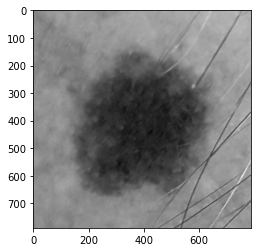

In [7]:
filename = df_hair_test['img_id'].iloc[7]
filename = str(pad_ufes.IMAGES_DIR / filename)
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

In [8]:
H_elems = feature.hessian_matrix(img, sigma=1, order='rc')
result = feature.hessian_matrix_eigvals(H_elems)

In [9]:
for item in result:
    print(np.min(item), np.max(item))

-0.04231774172630397 0.08737159026628444
-0.09270593887031786 0.013257050094094454


In [10]:
img_black_hair = result[0]
img_black_hair[img_black_hair < 0] = 0

img_white_hair = -result[1]
img_white_hair[img_white_hair < 0] = 0

In [11]:
img_paper_black_hair = (3.0 * result[0] + result[1]) / 2.0
img_paper_white_hair = (3.0 * result[1] + result[0]) / 2.0


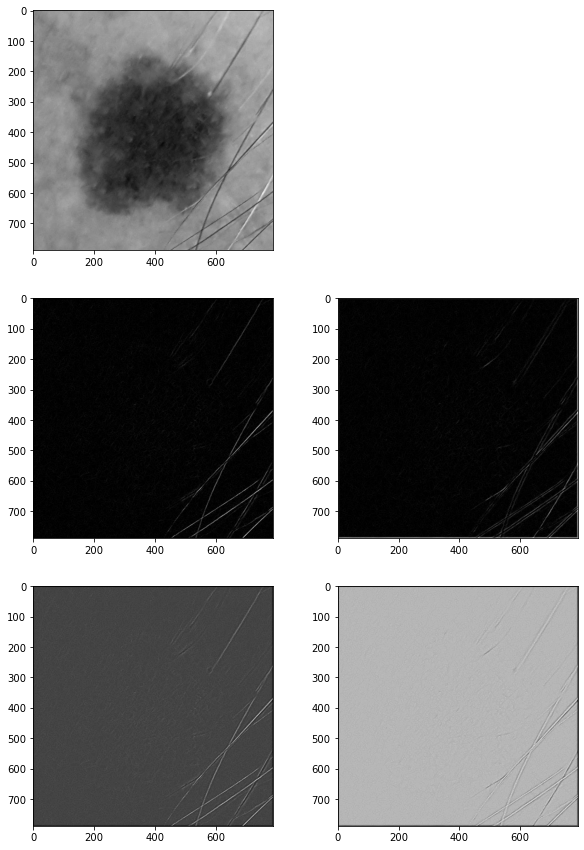

In [22]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(3, 2, 3)
plt.imshow(img_black_hair, cmap='gray')
plt.subplot(3, 2, 4)
plt.imshow(img_white_hair, cmap='gray')
plt.subplot(3, 2, 5)
# plt.imshow(result[0] > 0.02, cmap='gray')
# plt.subplot(3, 2, 6)
# plt.imshow(result[1] < -0.02, cmap='gray')
# plt.show()


plt.imshow(img_paper_black_hair, cmap='gray')
plt.subplot(3, 2, 6)
plt.imshow(img_paper_white_hair, cmap='gray')
plt.show()

In [13]:
def remove_hairs(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H_elems = feature.hessian_matrix(gray, sigma=1, order='rc')
    result = feature.hessian_matrix_eigvals(H_elems)
    
    
    img_black_hair = result[0]
    img_black_hair[img_black_hair < 0] = 0

    img_white_hair = -result[1]
    img_white_hair[img_white_hair < 0] = 0
    
    img_paper_black_hair = (3.0 * result[0] + result[1]) / 2.0
    img_paper_white_hair = (3.0 * result[1] + result[0]) / 2.0

    # print(img_paper_white_hair.shape)
    
    img_paper_black_hair_t= np.float32(result[0] > 0.02)
    img_paper_white_hair_t = np.float32(result[1] < -0.02)

    ret, thresh_black = cv2.threshold(img_paper_black_hair_t, np.median(img_paper_black_hair), 255, cv2.THRESH_BINARY)
    ret, thresh_white = cv2.threshold(img_paper_white_hair_t, np.median(img_paper_white_hair), 255, cv2.THRESH_BINARY)

    # plt.imshow(img_paper_black_hair, cmap='gray')
    # print(img_paper_black_hair.shape)
    
    dst_black = cv2.inpaint(img,img_paper_white_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)
    dst_white = cv2.inpaint(dst_black,img_paper_black_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)

    dst_black_t = cv2.inpaint(img,thresh_black.astype('uint8'),2,cv2.INPAINT_TELEA)
    dst_white_t = cv2.inpaint(img,thresh_white.astype('uint8'),2,cv2.INPAINT_TELEA)
    
    return ( dst_black, dst_white, dst_black_t, dst_white_t, thresh_black, thresh_white, img_paper_black_hair,  img_paper_white_hair, img_paper_black_hair_t, img_paper_white_hair_t )
    
#     plt.imshow(result > 0.02, cmap='gray')
#     plt.subplot(3, 2, 6)
#     plt.imshow(result[1] < -0.02, cmap='gray')


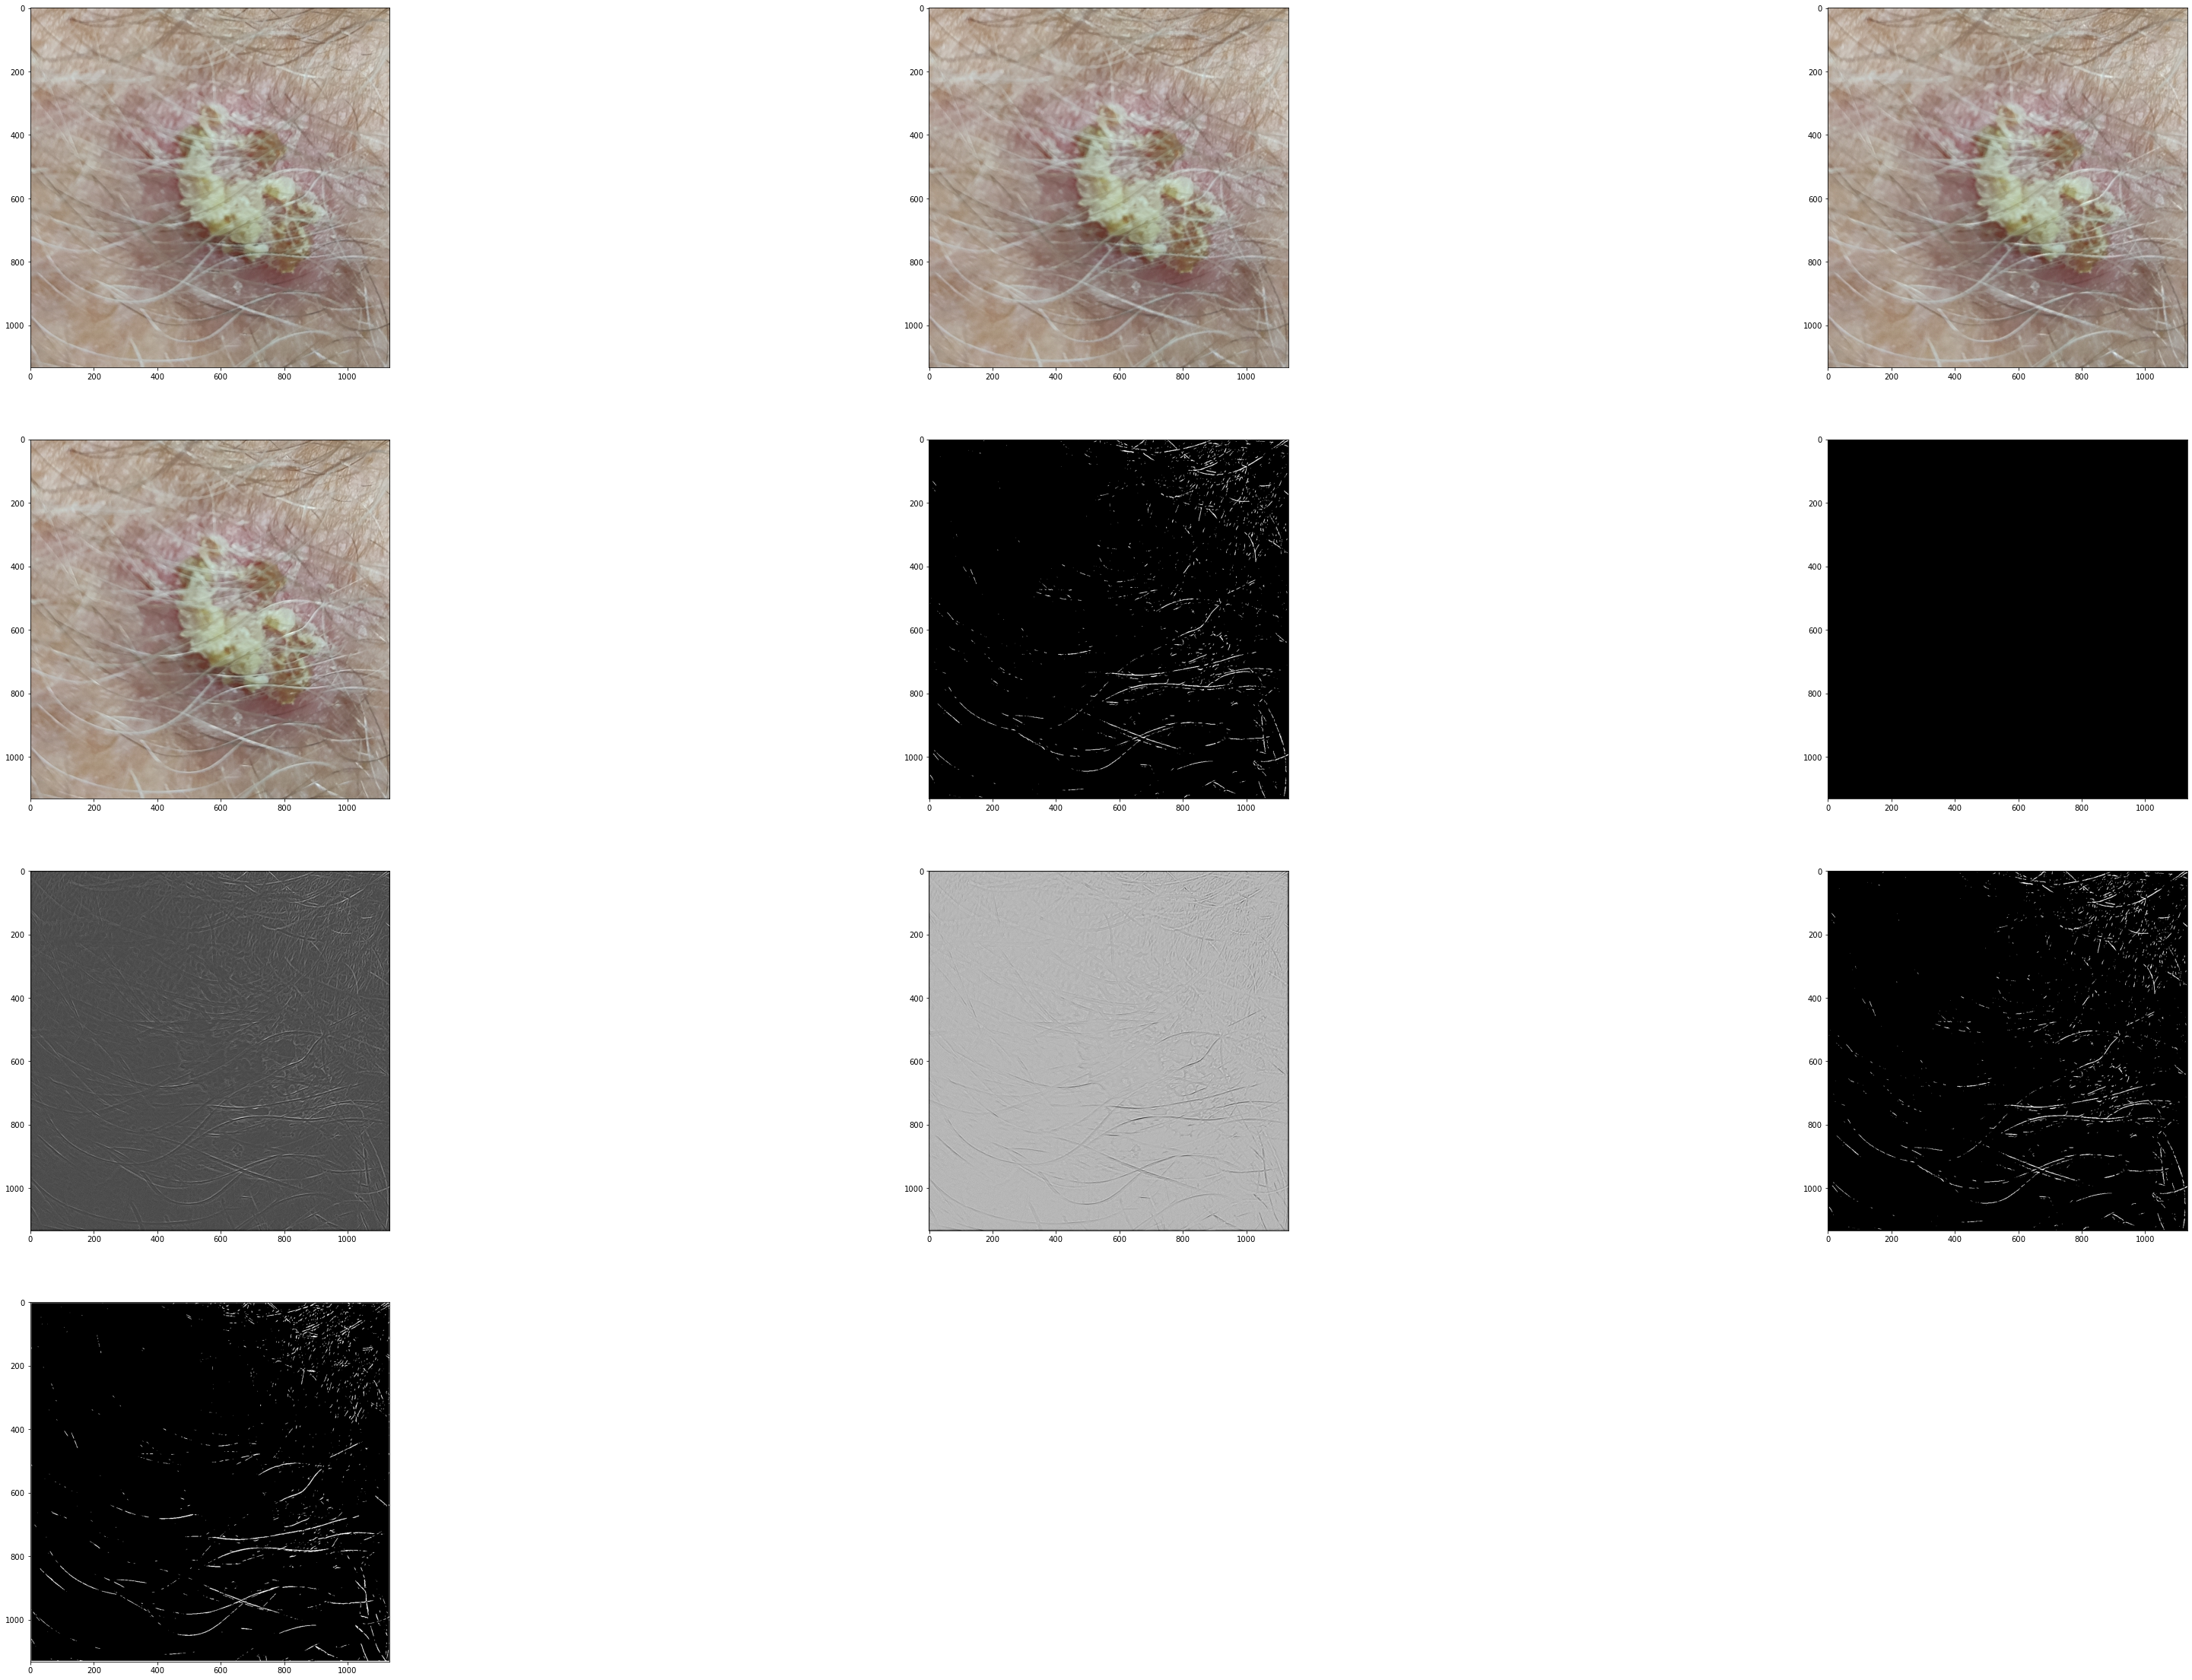

In [ ]:
for r in range(len(results)):
    image_sampling.image_grid(results[r])

# HOG test

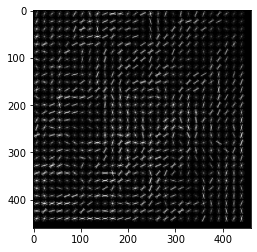

In [27]:
filename = df_hair_test['img_id'].iloc[0]
filename = str(pad_ufes.IMAGES_DIR / filename)
img = cv2.imread(filename)

fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)


# Derivative of Gaussian (DOG) Method
##### Hair removal methods: A comparative study for dermoscopy images

In [45]:
# Hair removal methods: A comparative study for dermoscopy images
# https://faculty.uca.edu/ecelebi/documents/BSPC_2011.pdf
# https://notebook.community/darshanbagul/ComputerVision/EdgeDetection-ZeroCrossings/EdgeDetectionByZeroCrossings

def hair_removal_dog(img):
        DoG_kernel = [
                    [0,   0, -1, -1, -1, 0, 0],
                    [0,  -2, -3, -3, -3,-2, 0],
                    [-1, -3,  5,  5,  5,-3,-1],
                    [-1, -3,  5, 16,  5,-3,-1],
                    [-1, -3,  5,  5,  5,-3,-1],
                    [0,  -2, -3, -3, -3,-2, 0],
                    [0,   0, -1, -1, -1, 0, 0]
                ] 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dog_img = convolve2d(gray, DoG_kernel, mode="same")

        # plt.imshow(dog_img, cmap=plt.cm.gray)
        # plt.show()

        img[dog_img == 255 ] = 0
        # dog_img[dog_img > 250] = 0
        # plt.imshow(img, cmap=plt.cm.gray)
        # plt.show()

        print(img.shape, dog_img.shape)

        bitwiseNot = cv2.bitwise_not(dog_img)
        # plt.imshow(bitwiseNot, cmap=plt.cm.gray)
        # plt.show()

        dog_img[dog_img > 250] = 0
        # plt.imshow(dog_img, cmap=plt.cm.gray)
        # plt.show()

        kernel = np.ones((3,3),np.uint8)
        dilation = cv2.dilate(dog_img.astype('uint8'),kernel,iterations = 1)


        final_img = cv2.inpaint(img,dilation.astype('uint8'),1,cv2.INPAINT_NS)
        plt.imshow(final_img, cmap=plt.cm.gray)
        # plt.show()

        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        plt.imshow(closing, cmap=plt.cm.gray)
        plt.show()


In [50]:
def load_selected_img(n):
    filename = df_hair_test['img_id'].iloc[n]
    filename = str(pad_ufes.IMAGES_DIR / filename)
    img = cv2.imread(filename)[:,:,::-1]
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    return img

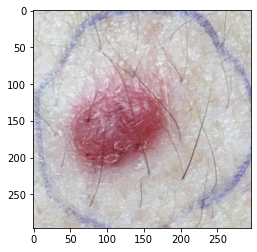

(296, 296, 3) (296, 296)


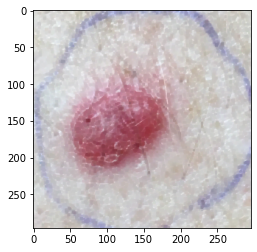

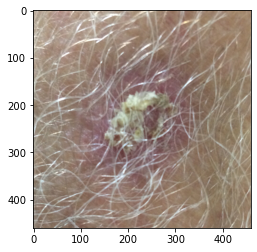

(460, 460, 3) (460, 460)


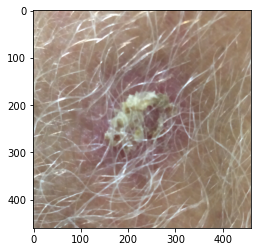

In [51]:
img = load_selected_img(10)
hair_removal_dog(img)
img = load_selected_img(0)
hair_removal_dog(img)



### Test: Remove light hairs as darker ones 

In [52]:
def subtract_pxs_from_channel(channel, mask):
    rows,cols=channel.shape
    for r in range(rows):
        for c in range(cols):
            # sub = channel[r][c]-mask[r][c]
            # if sub>0:
            #     channel[r][c] = sub
            # else:
            #     channel[r][c] = 0.0
            if mask[r][c]!=0:
                channel[r][c]=0
    return channel

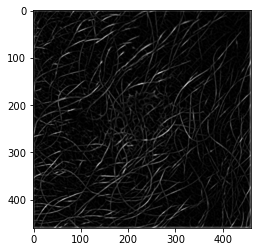

(460, 460)


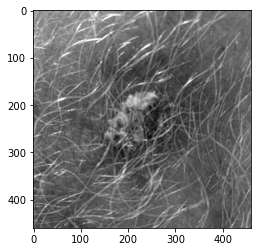

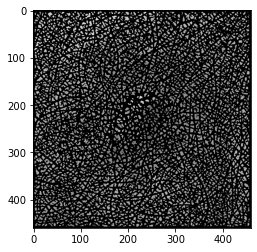

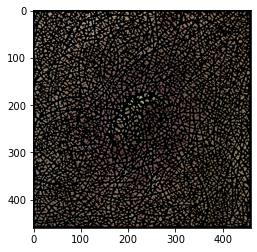

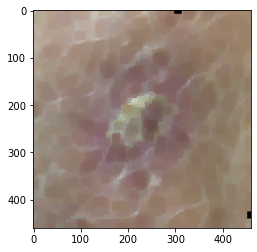

In [118]:
filename = df_hair_test['img_id'].iloc[0]
filename = str(pad_ufes.IMAGES_DIR / filename)
img = cv2.imread(filename)[:,:,::-1]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
H_elems = feature.hessian_matrix(gray, sigma=1, order='rc')
result = feature.hessian_matrix_eigvals(H_elems)

img_black_hair = result[0]
img_black_hair[img_black_hair < 0] = 0

img_white_hair = -result[1]
img_white_hair[img_white_hair < 0] = 0

plt.imshow(img_white_hair)
plt.show()

r, g, b = cv2.split(img)
print(b.shape)
plt.imshow(r, cmap=plt.cm.gray)
plt.show()
# plt.imshow(g, cmap=plt.cm.gray)
# plt.show()
# plt.imshow(b, cmap=plt.cm.gray)
# plt.show()


final_r = subtract_pxs_from_channel(r,img_white_hair)
final_g = subtract_pxs_from_channel(g,img_white_hair)
final_b = subtract_pxs_from_channel(b,img_white_hair)

plt.imshow(final_r, cmap=plt.cm.gray)
plt.show()
# plt.imshow(final_g, cmap=plt.cm.gray)
# plt.show()
# plt.imshow(final_b, cmap=plt.cm.gray)
# plt.show()

final = cv2.merge([final_r, final_g, final_b])

plt.imshow(final)
plt.show()

kernel = np.ones((15,15),np.uint8)
closing = cv2.morphologyEx(final, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.show()

# dst_black = cv2.inpaint(img,img_paper_white_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)
# dst_white = cv2.inpaint(dst_black,img_paper_black_hair_t.astype('uint8'),2,cv2.INPAINT_TELEA)

# dst_black_t = cv2.inpaint(img,thresh_black.astype('uint8'),2,cv2.INPAINT_TELEA)
# dst_white_t = cv2.inpaint(img,thresh_white.astype('uint8'),2,cv2.INPAINT_TELEA)

    


### Test: Changing colorspace

Idea: A comprehensive survey on image-based computer aided diagnosis systems for skin cancer

https://www.researchgate.net/profile/Nazia-Hameed-2/publication/316989945_A_comprehensive_survey_on_image-based_computer_aided_diagnosis_systems_for_skin_cancer/links/5b88ff7f4585151fd13ddb1b/A-comprehensive-survey-on-image-based-computer-aided-diagnosis-systems-for-skin-cancer.pdf


In [57]:
def remove_hairs_lab_lchannel(img):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    kernel = cv2.getStructuringElement(1,(17,17))
    edges = cv2.morphologyEx(l_channel, cv2.MORPH_BLACKHAT, kernel)
    ret,thresh = cv2.threshold(edges,10,255,cv2.THRESH_BINARY)
    dst = cv2.inpaint(img,thresh,1,cv2.INPAINT_TELEA)
    
    return dst

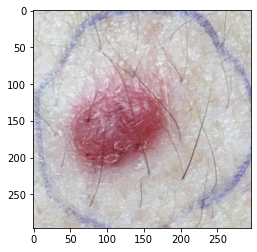

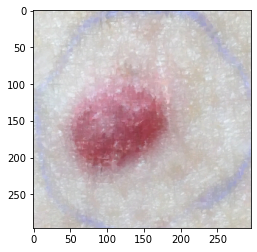

In [60]:
img = load_selected_img(10)
plt.imshow(remove_hairs_lab_lchannel(img))

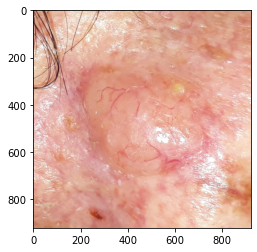

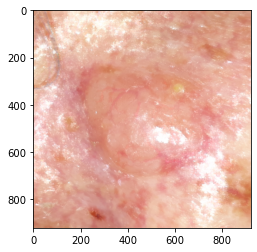

In [64]:
img = load_selected_img(6)
plt.imshow(remove_hairs_lab_lchannel(img))

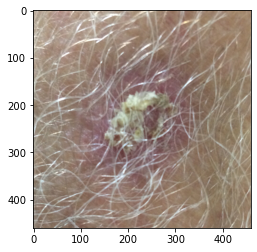

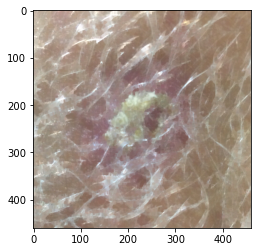

In [65]:
img = load_selected_img(0)
plt.imshow(remove_hairs_lab_lchannel(img))